<a href="https://colab.research.google.com/github/udtmhr/Othello/blob/main/Othello_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import random
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/OthelloAI')  # board.pyを使えるようにパスを通す

# 文字列の置いた場所をボードの番号に直す
def to_board_no(x, size=8):
    return ord(x[0]) - ord("a") + size * (int(x[1]) - 1)

# dataframeを作る
def to_dataframe(path):
    df = pd.read_csv(path, encoding="utf-8")
    df = df["record"].str.extractall("(..)")
    df.columns = ["move_str"]
    df["move_int"] = df["move_str"].apply(to_board_no)
    df.index.names = ["id", "move_no"]
    return df

# df = to_dataframe("/content/drive/MyDrive/Colab Notebooks/OthelloAI/wthor_csv/WTH_2023.csv")
# df.tail()

In [ ]:
from board import Board


# ビットボードを配列に直す
def to_array(bitboard):
    return np.array(list(bin(bitboard)[2:].zfill(64)), dtype=np.uint8)

# ビットボードの部分列を入れ替える
def delta_swap(x, mask, delta):
    t = t = (x ^ (x >> delta)) & mask
    return x ^ t ^ (t << delta)

# ビットボードを左右反転
def fliplr(x):
    x = delta_swap(x, 0x5555555555555555, 1)
    x = delta_swap(x, 0x3333333333333333, 2)
    return delta_swap(x, 0x0F0F0F0F0F0F0F0F, 4)

# ビットボードを左上から右下の対角線で反転
def flipuldr(x):
    x = delta_swap(x, 0x00AA00AA00AA00AA, 7)
    x = delta_swap(x, 0x0000CCCC0000CCCC, 14)
    return delta_swap(x, 0x00000000F0F0F0F0, 28)

# ビットボードを時計回りに９０度回転
def rot90(x):
    return fliplr(flipuldr(x))

board = Board()
def make_data(df, x_train, y_train):
    for i in df.index.levels[0]:
        for _, _, pos in df.loc[i].itertuples():
            pos = 0x8000000000000000 >> pos
            pb, ob = board.pb, board.ob
            rev = board.reverse(pos)
            board.put(pos, rev)
            board.next_player()
            # 元の譜面
            x_train.append(np.array([to_array(pb).reshape((8, 8)), to_array(ob).reshape((8, 8))], dtype=np.uint8))
            y_train.append(to_array(pos))
            # 時計回りに９０度を３回
            for _ in range(3):
                pb, ob = rot90(pb), rot90(ob)
                pos = rot90(pos)
                x_train.append(np.array([to_array(pb).reshape((8, 8)), to_array(ob).reshape((8, 8))], dtype=np.uint8))
                y_train.append(to_array(pos))
            # 転置した譜面
            pb, ob = flipuldr(rot90(pb)), flipuldr(rot90(ob))
            pos = flipuldr(rot90(pos))
            x_train.append(np.array([to_array(pb).reshape((8, 8)), to_array(ob).reshape((8, 8))], dtype=np.uint8))
            y_train.append(to_array(pos))
            # 時計回りに９０度を３回
            for _ in range(3):
                pb, ob = rot90(pb), rot90(ob)
                pos = rot90(pos)
                x_train.append(np.array([to_array(pb).reshape((8, 8)), to_array(ob).reshape((8, 8))], dtype=np.uint8))
                y_train.append(to_array(pos))
        board.init()

In [ ]:
x_train = []
y_train =
dir_path = "/content/drive/MyDrive/Colab Notebooks/OthelloAI/wthor_csv"
file_lst = os.listdir(dir_path)
for file in file_lst[23:]: # メモリ不足にならないよう２０００年以降から
    print(file)
    df = to_dataframe(os.path.join(dir_path, file))
    make_data(df, x_train, y_train)

In [ ]:
x_train = np.array(x_train, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)

In [ ]:
data_size = y_train.shape[0]
rand = np.random.choice(data_size, data_size, replace=False)
x_train =  x_train[rand,:,:]
y_train = y_train[rand]
del rand


In [ ]:
np.savez_compressed("/content/drive/MyDrive/Colab Notebooks/OthelloAI/learn data/x_train.npz", x_train)
np.savez_compressed("/content/drive/MyDrive/Colab Notebooks/OthelloAI/learn data/y_train.npz", y_train)

In [ ]:
del x_train, y_train

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
class Bias(keras.layers.Layer):
    def __init__(self, input_shape):
        super(Bias, self).__init__()
        self.w = tf.Variable(initial_value=tf.zeros(input_shape[1:]), trainable=True)

    def call(self, inputs):
        return inputs + self.w

model = models.Sequential()
model.add(layers.Permute((2,3,1), input_shape=(2,8,8)))
model.add(layers.Conv2D(128, kernel_size=3,padding='same', activation='relu'))
model.add(layers.Conv2D(128, kernel_size=3,padding='same',activation='relu'))
model.add(layers.Conv2D(128, kernel_size=3,padding='same',activation='relu'))
model.add(layers.Conv2D(128, kernel_size=3,padding='same',activation='relu'))
model.add(layers.Conv2D(128, kernel_size=3,padding='same',activation='relu'))
model.add(layers.Conv2D(128, kernel_size=3,padding='same',activation='relu'))
model.add(layers.Conv2D(128, kernel_size=3,padding='same',activation='relu'))
model.add(layers.Conv2D(128, kernel_size=3,padding='same',activation='relu'))
model.add(layers.Conv2D(128, kernel_size=3,padding='same',activation='relu'))
model.add(layers.Conv2D(128, kernel_size=3,padding='same',activation='relu'))
model.add(layers.Conv2D(128, kernel_size=3,padding='same',activation='relu'))
model.add(layers.Conv2D(128, kernel_size=3,padding='same',activation='relu'))
model.add(layers.Conv2D(1, kernel_size=1,use_bias=False))
model.add(layers.Flatten())
model.add(Bias((1, 64)))
model.add(layers.Activation('softmax'))

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/Colab Notebooks/OthelloAI/model"

if not os.path.exists(MODEL_DIR):  # ディレクトリが存在しない場合、作成する。
    os.makedirs(MODEL_DIR)
checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "model-{epoch:02d}.h5"), save_best_only=True)

x_train = np.load("/content/drive/MyDrive/Colab Notebooks/OthelloAI/learn data/x_train.npz")["arr_0"]
y_train = np.load("/content/drive/MyDrive/Colab Notebooks/OthelloAI/learn data/y_train.npz")["arr_0"]
try:
    history = model.fit(x_train, y_train, batch_size=1024, epochs=25, validation_split=0.1, callbacks=[checkpoint])
except KeyboardInterrupt:
    model.save('saved_model/my_model')

Epoch 1/25
28776/28776 [==============================] - 971s 33ms/step - loss: 1.1495 - accuracy: 0.5661 - val_loss: 1.0633 - val_accuracy: 0.5939
Epoch 2/25
28776/28776 [==============================] - 968s 34ms/step - loss: 1.0459 - accuracy: 0.6004 - val_loss: 1.0438 - val_accuracy: 0.6024
Epoch 3/25
28776/28776 [==============================] - 973s 34ms/step - loss: 1.0275 - accuracy: 0.6074 - val_loss: 1.0237 - val_accuracy: 0.6084
Epoch 4/25
28776/28776 [==============================] - 978s 34ms/step - loss: 1.0186 - accuracy: 0.6108 - val_loss: 1.0273 - val_accuracy: 0.6072
Epoch 5/25
28776/28776 [==============================] - 965s 34ms/step - loss: 1.0131 - accuracy: 0.6128 - val_loss: 1.0230 - val_accuracy: 0.6113
Epoch 6/25
 5295/28776 [====>.........................] - ETA: 12:40 - loss: 1.0047 - accuracy: 0.6160

In [ ]:
data = np.array([[
[[0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0],
 [0,0,0,0,1,0,0,0],
 [0,0,0,1,0,0,0,0],
 [0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0]],

[[0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0],
 [0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0]]]],dtype=np.int8)
probability = model.predict(data)
probability

1/1 [==============================] - 0s 35ms/step


array([[3.6638582e-08, 8.4647169e-08, 2.8491817e-08, 2.0508621e-08,
        5.2463847e-09, 2.7259295e-09, 2.3414422e-09, 2.3354318e-11,
        2.9009786e-09, 4.3094904e-08, 3.0946293e-07, 1.6065378e-08,
        2.2296813e-09, 1.8013090e-10, 7.8230492e-11, 1.6611569e-10,
        3.0897884e-10, 1.5876205e-09, 1.6364149e-09, 2.5540057e-01,
        8.6800282e-11, 1.4989336e-10, 1.2408100e-10, 3.5474956e-11,
        2.2891827e-10, 7.4231870e-08, 2.6526859e-01, 1.3733800e-11,
        3.1104529e-11, 1.1962960e-08, 2.6064486e-09, 5.4200457e-11,
        2.9209331e-09, 2.9109733e-08, 3.5129506e-09, 1.7047874e-11,
        3.7022377e-12, 2.3173106e-01, 9.5098018e-09, 4.9624429e-09,
        2.9905362e-08, 1.8510121e-08, 2.3488405e-09, 9.4172727e-08,
        2.4758957e-01, 1.3876728e-07, 7.2643292e-07, 2.7618444e-07,
        8.5080160e-08, 7.8847037e-08, 3.7782041e-08, 7.9147782e-08,
        5.7072390e-07, 1.6278820e-07, 4.0852402e-08, 2.5768015e-06,
        1.1921380e-06, 1.2920663e-07, 7.4463586e

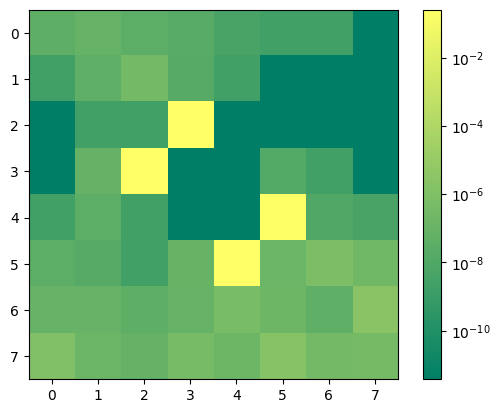

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

cmap = plt.get_cmap('summer')
plt.imshow(probability.reshape((8, 8)), cmap=cmap, norm=LogNorm())
plt.colorbar()
plt.show()